<a href="https://colab.research.google.com/github/sayanarajasekhar/PyTorch/blob/main/Multi_class_classification_problem_make_gaussian_quantiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class classification problem `make_gaussian_quantiles` with `2 features` and `3 labels`

## 1. Import Libraries

In [465]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## 2. Creating device agonistic code

In [466]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 3. Make a multi-class classification dataset with Scikit-Learn's `make_gaussian_quantiles()` function.

In [467]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

N_SAMPLES = 1000
N_FEATURES = 2
N_CLASSES = 3

X, y = make_gaussian_quantiles(
    n_samples = N_SAMPLES,
    n_features = N_FEATURES,
    n_classes = N_CLASSES,
    shuffle = True,
    random_state = 42
)

len(X), len(y)

(1000, 1000)

In [468]:
X.shape, y.shape

((1000, 2), (1000,))

## 4. Visualize data

In [469]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "labels": y})
circles.head(10)

,X1,X2,labels
0,1.644968,-0.249036,2
1,1.189470,-1.227608,2
2,0.069802,-0.385314,0
3,1.846637,-1.070085,2
4,0.361636,-0.645120,0
5,-0.699726,0.213980,0
6,-1.870792,-0.351513,2
7,-0.315269,0.758969,0
8,1.076007,0.021312,1
9,-1.724918,-0.562288,2


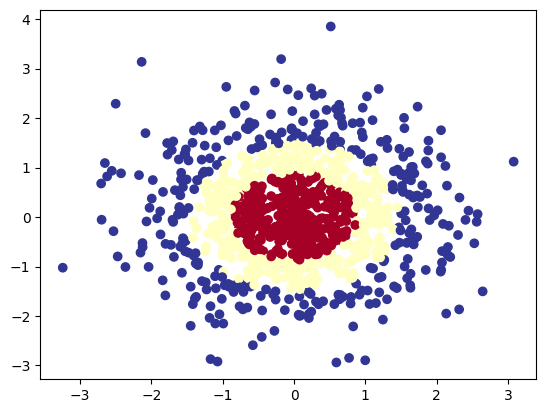

In [470]:
# Visualization data in plt
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

## 5. Split train and test data

In [471]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 6. Building a model with non-linearity

In [472]:
class GaussianQuantiles(nn.Module):
  def __init__(self, features, classes, nodes = 10):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features = features, out_features = nodes),
      nn.ReLU(),
      nn.Linear(in_features = nodes, out_features = nodes),
      nn.ReLU(),
      nn.Linear(in_features = nodes, out_features = classes)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layers(x).squeeze()

In [473]:
torch.manual_seed(42)
model_0 = GaussianQuantiles(N_FEATURES, N_CLASSES)
model_0

GaussianQuantiles(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

## 7. Create Loss function and Optimizer

In [474]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(),
                            lr = 0.01)

## 8. Training and Testing loop

In [475]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [476]:
epochs = 1000

train_loss_data = []
train_acc_data = []
test_loss_data = []
test_acc_data = []
epoch_count = []

for epoch in range(epochs):

  ### Train
  model_0.train()

  # 1. Forward pass
  train_logits = model_0(X_train)
  train_preds = torch.softmax(train_logits, dim = 1).argmax(dim = 1)

  # 2. Calculate loss / accuracy
  train_loss = loss_fn(train_logits, y_train)
  train_acc = accuracy(y_true = y_train, y_pred = train_preds)
  train_loss_data.append(train_loss.detach().numpy())
  train_acc_data.append(train_acc)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  train_loss.backward()

  # 5. Optimize step
  optimizer.step()

  ### Test
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    # 2. Calculate loss / accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(y_true = y_test, y_pred = test_preds)
    test_loss_data.append(test_loss.detach().numpy())
    test_acc_data.append(test_acc)

  if epoch % 100 == 0:
    epoch_count.append(epoch)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f} Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 1.10965 Acc: 32.62% | Test Loss: 1.10214 Acc: 36.50%
Epoch: 100 | Train Loss: 0.16669 Acc: 97.62% | Test Loss: 0.14898 Acc: 97.50%
Epoch: 200 | Train Loss: 0.05406 Acc: 99.25% | Test Loss: 0.05028 Acc: 98.50%
Epoch: 300 | Train Loss: 0.03355 Acc: 99.50% | Test Loss: 0.03923 Acc: 99.00%
Epoch: 400 | Train Loss: 0.02425 Acc: 99.75% | Test Loss: 0.03641 Acc: 99.00%
Epoch: 500 | Train Loss: 0.01846 Acc: 99.88% | Test Loss: 0.03482 Acc: 99.00%
Epoch: 600 | Train Loss: 0.01475 Acc: 100.00% | Test Loss: 0.03455 Acc: 99.00%
Epoch: 700 | Train Loss: 0.01213 Acc: 99.88% | Test Loss: 0.03567 Acc: 98.50%
Epoch: 800 | Train Loss: 0.01024 Acc: 100.00% | Test Loss: 0.03637 Acc: 98.50%
Epoch: 900 | Train Loss: 0.00867 Acc: 100.00% | Test Loss: 0.04068 Acc: 98.50%


In [477]:
# Importing libraries from different git repo's

import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists, skipping download")
else:
  response = requests.get("https://raw.githubusercontent.com/sayanarajasekhar/PyTorch/refs/heads/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(response.content)

helper_functions.py already exists, skipping download


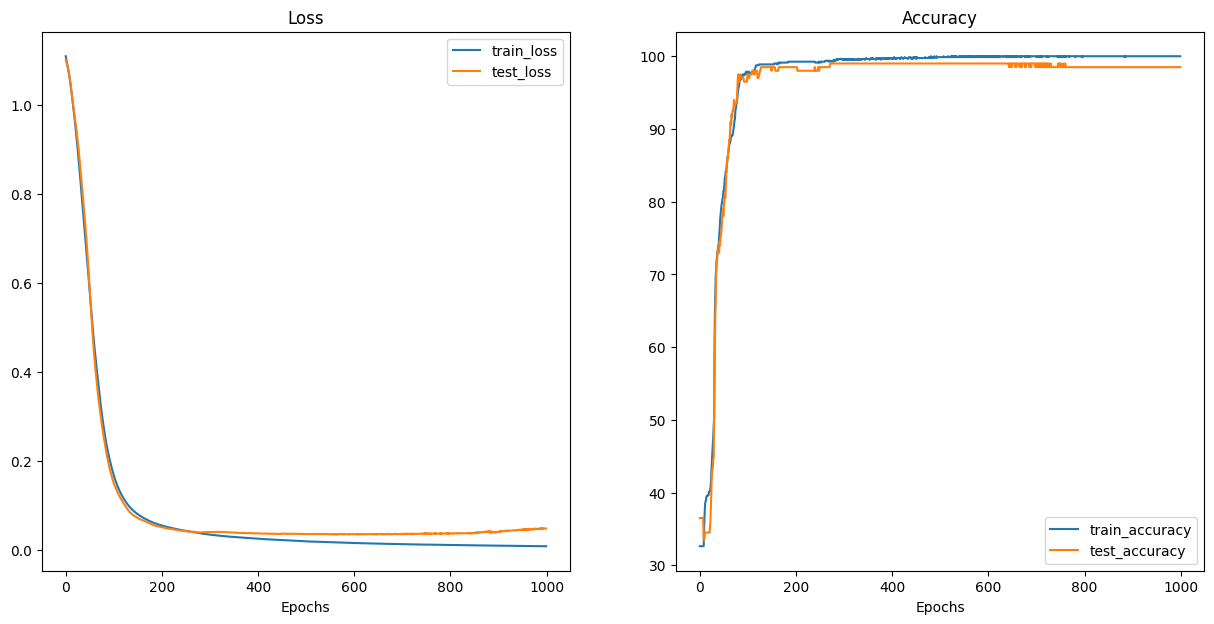

In [478]:
from helper_functions import plot_loss_curves
plot_loss_curves({
    'train_loss': train_loss_data,
    'train_acc': train_acc_data,
    'test_loss': test_loss_data,
    'test_acc': test_acc_data
})

Now the model_0 with `2 feature` and `3 labels`  - > **Test Loss**: `0.04068` **Accuracy**: `98.50%`

# Multi-class classification problem `make_gaussian_quantiles` with `5 features` and `3 labels`

Lets tests `model_0` with `5 features` and `3 labesl` and see how it performs

Create new set of data

In [579]:
SAMPLES = 1000
NUM_FEATURES = 5
NUM_CLASSES = 3

X5, y2 = make_gaussian_quantiles(n_samples = SAMPLES,
                                 n_features = NUM_FEATURES,
                                 n_classes = NUM_CLASSES,
                                 shuffle = True,
                                 random_state = 42)

X5 = torch.from_numpy(X5).type(torch.float)
y2 = torch.from_numpy(y2).type(torch.LongTensor)

X5_train, X5_test, y2_train, y2_test = train_test_split(X5, y2, test_size = 0.2, random_state = 42)

len(X5), len(X5_train), len(X5_test)

(1000, 800, 200)

Lets create a `model_1` with dynamic net which will change hidden layers dynamically

In [580]:
import array

class DynamicNet(nn.Module):
  def __init__(self, in_feature, hidden_layers: array.array, out_feature):
    super().__init__()
    layers = []
    pre_layer = in_feature

    # Creating hidden layers dynamically
    for hidden_layer in hidden_layers:
      layers.append(nn.Linear(in_features = pre_layer, out_features = hidden_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(0.3))
      pre_layer = hidden_layer

    # Final layer matching out_features
    layers.append(nn.Linear(in_features = pre_layer, out_features = out_feature))

    # Combining all layers
    self.net = nn.Sequential(*layers)

  def forward(self, x:torch.tensor)-> torch.tensor:
    return self.net(x)

In [581]:
model_1 = DynamicNet(in_feature = NUM_FEATURES, hidden_layers = [8, 16, 8], out_feature = NUM_CLASSES)
model_1

DynamicNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=8, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [582]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), weight_decay = 1e-3,
                             lr = 0.001)

In [583]:
epochs = 1000

train_loss_data = []
train_acc_data = []
test_loss_data = []
test_acc_data = []
epoch_count = []

for epoch in range(epochs):
  ### Train
  model_1.train()

  # 1. Forward pass
  train_logits = model_1(X5_train).squeeze()
  train_preds = torch.softmax(train_logits, dim = 1).argmax(dim = 1)

  # 2. Calculate loss/acc
  train_loss = loss_fn(train_logits, y2_train)
  train_acc = accuracy(y_true = y2_train, y_pred = train_preds)
  train_loss_data.append(train_loss.detach().numpy())
  train_acc_data.append(train_acc)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  train_loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Test
  model_1.eval()
  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model_1(X5_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    # 2. Calculate loss / acc
    test_loss = loss_fn(test_logits, y2_test)
    test_acc = accuracy(y_true = y2_test, y_pred = test_preds)
    test_loss_data.append(test_loss.detach().numpy())
    test_acc_data.append(test_acc)

  if epoch % 100 == 0:
    epoch_count.append(epoch)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f} Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 1.15898 Acc: 33.38% | Test Loss: 1.15265 Acc: 33.00%
Epoch: 100 | Train Loss: 1.10508 Acc: 33.38% | Test Loss: 1.10362 Acc: 33.00%
Epoch: 200 | Train Loss: 1.07731 Acc: 37.25% | Test Loss: 1.05831 Acc: 46.50%
Epoch: 300 | Train Loss: 1.04728 Acc: 42.62% | Test Loss: 1.00263 Acc: 50.00%
Epoch: 400 | Train Loss: 1.02253 Acc: 46.38% | Test Loss: 0.95519 Acc: 58.50%
Epoch: 500 | Train Loss: 0.95085 Acc: 52.12% | Test Loss: 0.82605 Acc: 74.50%
Epoch: 600 | Train Loss: 0.90215 Acc: 57.25% | Test Loss: 0.74961 Acc: 74.50%
Epoch: 700 | Train Loss: 0.88034 Acc: 59.13% | Test Loss: 0.71738 Acc: 73.50%
Epoch: 800 | Train Loss: 0.88117 Acc: 56.62% | Test Loss: 0.69844 Acc: 72.50%
Epoch: 900 | Train Loss: 0.88204 Acc: 55.12% | Test Loss: 0.68373 Acc: 75.00%


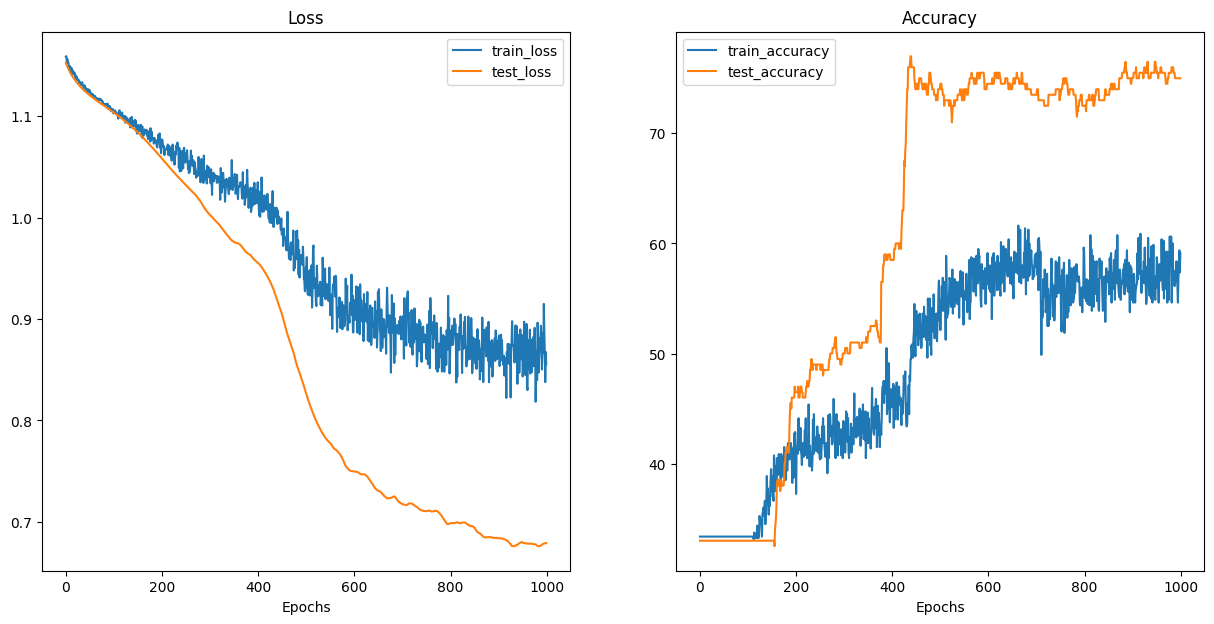

In [584]:
plot_loss_curves({
    'train_loss': train_loss_data,
    'train_acc': train_acc_data,
    'test_loss': test_loss_data,
    'test_acc': test_acc_data
})

[[63  2  0]
 [24 22 20]
 [ 0  4 65]]


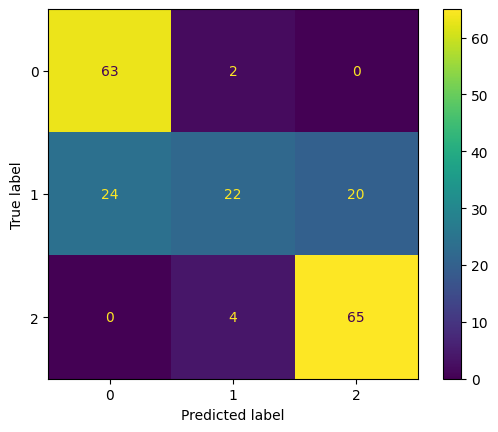

In [585]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true = y2_test, y_pred = test_preds)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()